In [12]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Session 15
## Pytorch Framework Demo
- one hidden layer 
- ${tanh}$ activation function
- multi-class output
- FIFA dataset
- pytorch implementation Custom Dataset Class with loader


<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [13]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd

from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

In [14]:
###----------------------
### Some basic parameters
###----------------------

inpDir = 'input'
outDir = '../output'
modelDir = '../models'
modelSubDir = 'pytorch_fifa'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 51 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

In [15]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, modelSubDir)):
    os.makedirs(os.path.join(modelDir, modelSubDir))
    print ('Created {} directory'.format(os.path.join(modelDir, modelSubDir)))

## Helper Functions

In [16]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)
    
    # Where was min loss
    best = hist_df[hist_df['test_loss'] == hist_df['test_loss'].min()]
    
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = 'epoch', y = ['loss', 'test_loss'], ax = ax)

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1]['loss'],
                           loss_df.iloc[-1]['test_loss']) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best["test_loss"].to_numpy()[0]:6.4f}', # text to print
                xy=(best['epoch'].to_numpy(), best["test_loss"].to_numpy()[0]), # Arrow start
                xytext=(best['epoch'].to_numpy()+0.01, best["test_loss"].to_numpy()[0]+0.01), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best['epoch'].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = 'epoch', y = ['acc', 'test_acc'], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(loss_df.iloc[-1]['acc'],
                           loss_df.iloc[-1]['test_acc']) #text to plot
        
    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best["test_acc"].to_numpy()[0]:6.4f}', # text to print
                xy=(best['epoch'].to_numpy(), best["test_acc"].to_numpy()[0]), # Arrow start
                xytext=(best['epoch'].to_numpy(), best["test_acc"].to_numpy()[0]-0.01), # location of text 
                transform=ax.transAxes,
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05,), # arrow
                ) 
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best['epoch'].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Read FIFA 2019 data set
<img src = '../../images/fifa_2019.png' alt = 'Fifa 2019'>

In [17]:
data_df = pd.read_csv(os.path.join('/home/hpcsap/Ai_ML/directory_env/fifa_2019.csv'))
data_df.shape

(18207, 89)

In [18]:
# removing rows with position == null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [19]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [20]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [21]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Helps in preventing pandas from complaining while get_dummies
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [22]:
# Keeping relevent columns.
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [23]:
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
train_df.shape, test_df.shape

((14517, 34), (3630, 34))

## All about CUDA

In [24]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  False
CUDA version:  12.1


RuntimeError: No CUDA GPUs are available

In [25]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


## Custom DataSet

In [26]:
'''Using Singleton design pattern'''

class GlobalScaler:
    _instance = None
    
    def __init__ (self):
        if GlobalScaler._instance is not None:
            raise Exception ("GlobalScaler class is a singleton.")

        self.scaler = StandardScaler()
        
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = GlobalScaler()
        return cls._instance

In [28]:
'''
In this code, we define a custom dataset called RandomDS that takes a DataFrame as input. 

'''

class RandomDS(Dataset):
    globalScaler = GlobalScaler.get_instance() # private instance variable
    
    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 device : str = device, 
                 is_train = True,
                 label_col = None
                ):
        
        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.scaler = self.globalScaler.scaler
        self.label_col = label_col
        
        if self.is_train:
            self.labels = self.df[label_col].to_numpy()
            X = self.df.drop(label_col, axis = 1)
            self.features = self.scaler.fit_transform(X) # fit transform train set 
        else:
            self.labels = self.df[label_col]
            X = self.df.drop(label_col, axis = 1)
            self.features = self.scaler.transform(X) # transform only test set 
        
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32, device=self.device)
        label = torch.tensor(label, dtype=torch.int64, device=self.device)
        
        return features, label

In [29]:
train_df = train_df.reset_index(drop=True)
train_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,62.0,57.0,51.0,47.0,61.0,42.0,27.0,41.0,59.0,...,63.0,52.0,21.0,16.0,12.0,11.0,7.0,10.0,12.0,11.0
1,3,55.0,42.0,58.0,60.0,62.0,61.0,56.0,52.0,60.0,...,60.0,53.0,29.0,25.0,22.0,7.0,12.0,6.0,9.0,10.0
2,2,56.0,36.0,61.0,51.0,69.0,60.0,52.0,57.0,66.0,...,54.0,50.0,23.0,22.0,27.0,12.0,10.0,9.0,9.0,14.0
3,0,11.0,12.0,35.0,12.0,12.0,22.0,13.0,40.0,20.0,...,20.0,60.0,11.0,10.0,15.0,69.0,70.0,66.0,67.0,73.0
4,2,66.0,44.0,66.0,48.0,70.0,74.0,75.0,62.0,67.0,...,76.0,60.0,40.0,38.0,28.0,14.0,12.0,6.0,12.0,12.0


In [30]:
test_df = test_df.reset_index(drop=True)
test_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,2,66.0,33.0,72.0,55.0,81.0,69.0,65.0,61.0,79.0,...,57.0,68.0,23.0,26.0,30.0,12.0,14.0,16.0,6.0,10.0
1,2,71.0,43.0,68.0,43.0,72.0,74.0,69.0,70.0,78.0,...,64.0,66.0,39.0,26.0,16.0,14.0,14.0,13.0,6.0,8.0
2,2,67.0,43.0,61.0,49.0,65.0,48.0,35.0,44.0,65.0,...,54.0,47.0,49.0,13.0,19.0,9.0,12.0,15.0,12.0,13.0
3,2,55.0,37.0,69.0,45.0,67.0,50.0,51.0,64.0,62.0,...,53.0,61.0,55.0,61.0,57.0,13.0,7.0,10.0,8.0,12.0
4,1,25.0,82.0,61.0,20.0,51.0,25.0,33.0,63.0,60.0,...,42.0,67.0,77.0,78.0,70.0,15.0,12.0,13.0,14.0,15.0


In [31]:
label_col = 'Position'
train_ds = RandomDS(train_df, is_train = True, label_col = label_col)
test_ds = RandomDS(test_df, is_train = False, label_col = label_col)

## Prepare Network

In [32]:
class Model(nn.Module):
    
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,16)
        self.layer2 = nn.Linear(16, 4)
        
    def forward(self, x):
        x = F.tanh(self.layer1(x))
        #x = F.softmax(self.layer2(x), dim = 1)
        x = self.layer2(x)
        return x

net = Model(input_dim=train_df.shape[1]-1).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=4, bias=True)
)


In [33]:
# Define data loaders for the training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [34]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%10 == 0:
        print(f'At epoch {epoch:>3d} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch   0 | Loss - train:0.5755, test:0.3726 | Acc - train:0.7932, test:0.8477
At epoch  10 | Loss - train:0.2866, test:0.2964 | Acc - train:0.8823, test:0.8741
At epoch  20 | Loss - train:0.2780, test:0.2934 | Acc - train:0.8859, test:0.8793
At epoch  30 | Loss - train:0.2735, test:0.2947 | Acc - train:0.8861, test:0.8796
At epoch  40 | Loss - train:0.2696, test:0.2945 | Acc - train:0.8884, test:0.8813
At epoch  50 | Loss - train:0.2659, test:0.2976 | Acc - train:0.8896, test:0.8791


In [35]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.575483,0.372551,0.793208,0.847658
1,1,0.337817,0.331458,0.863815,0.856749
2,2,0.315357,0.316697,0.871117,0.865840
3,3,0.306069,0.311646,0.874836,0.866391
4,4,0.301549,0.306117,0.876490,0.871350


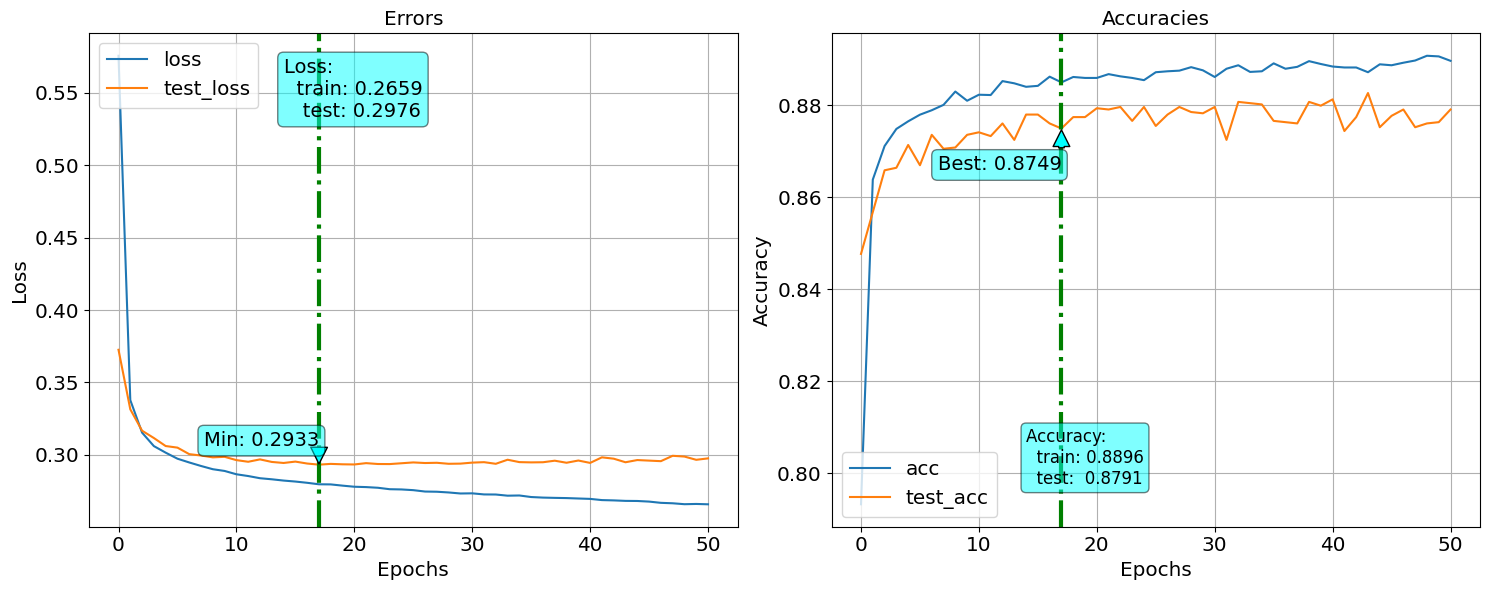

In [36]:
plot_hist(loss_df)